In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
#np.set_printoptions(precision=3)
np.set_printoptions(precision=4, suppress=True)
torch.manual_seed(101)
device = torch.device('cpu')

### Initialial visulation

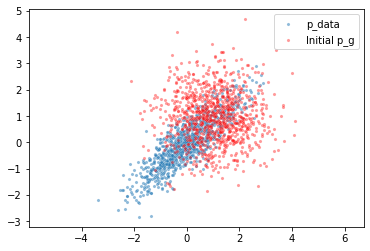

In [2]:
mu_p = torch.tensor([0.0, 0.0])
scale_p = torch.tensor([[1.0000, 0.0000],
                        [0.8, 0.5]])
cov_p = scale_p@scale_p.T

p_data = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu_p, covariance_matrix=cov_p)

mu_q = torch.tensor([1.0, 1.0])
scale_q = torch.tensor([[1.0, 0], [0, 1.0]])

cov_q = scale_q@scale_q.T
q_g = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu_q, covariance_matrix=cov_q)

x_p = p_data.sample([1000])
x_q = q_g.sample([1000])
sns.scatterplot(x=x_p[:, 0], y=x_p[:, 1], s=10, label='p_data', alpha=0.5)
sns.scatterplot(x=x_q[:, 0], y=x_q[:, 1], s=10, label='Initial p_g', color='r', alpha=0.4)
plt.axis('equal')
plt.legend()
plt.show()


In [3]:
criterion = nn.BCEWithLogitsLoss()

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, 1)
    
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        return self.fc3(x)
    
def D_train(net_D, opt_D, real, fake, batch_size, niter):
    
   
    for i in range(niter):
        x_real, y_real = real.view(-1, 2), torch.ones(batch_size, 1)
        x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
        x_fake, y_fake = fake, Variable(torch.zeros(batch_size, 1).to(device))
        opt_D.zero_grad()

        D_output = net_D(x_real)
        D_real_loss = criterion(D_output, y_real)
        D_real_score = D_output

        D_output = net_D(x_fake)
        D_fake_loss = criterion(D_output, y_fake)
        D_fake_score = D_output

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        opt_D.step()
        
    return  D_loss.data.item()

In [4]:
def f(r, method='Rkl'):
    if method=='Rkl':
        return -torch.log(r)
    elif method=='Fkl':
        return r*torch.log(r)
    elif method=='Chi':
        return (r-1)**2
    elif method=='Hellinger':
        return (torch.sqrt(r)-1)**2
    elif method=='Js':
        return -(r+1)*torch.log((1+r)/2) + r*torch.log(r)

def h(logr, method='Exp'):
    if method=='Exp':
        return torch.exp(1.5*logr)

def train(func='f', method='Rkl', number_iter=1000, lr=0.01, lr_d=1e-4, batch_size=1000):
    
    mu_q = torch.tensor([1.0, 1.0])
    scale_q = torch.tensor([[1.0, 0], [0, 1.0]])

    mu_q.requires_grad = True
    scale_q.requires_grad = True
    opt = torch.optim.Adam([mu_q, scale_q], lr=lr)
    
    logr_net = Discriminator(2)
    opt_d = torch.optim.Adam(logr_net.parameters(), lr=lr_d)
    
    for i in range(number_iter):
        
        # Train Discriminator
        
        z = torch.randn([batch_size, 2])
        fake = mu_q + z @ scale_q.T
        real = p_data.sample([batch_size])
        D_train(logr_net, opt_d, real, fake, batch_size, niter=1)
        
        #Train Generator
        opt.zero_grad()
        
        z = torch.randn([batch_size, 2])
        
        # reparameterization trick
        x = mu_q + z @ scale_q.T
        approx_log_ratio = logr_net(x)
        approx_r = torch.exp(approx_log_ratio)
        
        if func == 'f':
            loss = torch.mean(f(approx_r, method))
        if func == 'h':
            loss = -torch.mean(h(approx_log_ratio, method))  
        loss.backward()
        opt.step()
        
    print('Minimizing divergence:', method)
    print('mu_pg:')
    print(mu_q.detach().numpy())
    print('\ncov_pg:')
    print((scale_q @ scale_q.T).detach().numpy())
    
    
    z = torch.randn([1000, 2])
    fake = mu_q + z @ scale_q.T
    sns.scatterplot(x=x_p[:, 0], y=x_p[:, 1], s=10, label='p_data', alpha=0.7)
    sns.scatterplot(x=fake.detach()[:, 0], y=fake.detach()[:, 1], s=10, label='p_g', color='r', alpha=0.4)
    plt.axis('equal')
    plt.legend(prop={'size': 15})
    #plt.legend()
    plt.show()

In [5]:
print('Target distribution has parameters:')
print('mu:\n')
print(mu_p.numpy())
print('\ncov:\n')
print((scale_p @ scale_p.T).numpy())

Target distribution has parameters:
mu:

[0. 0.]

cov:

[[1.   0.8 ]
 [0.8  0.89]]


## GAN

Minimizing divergence: Rkl
mu_pg:
[-0.0104 -0.0157]

cov_pg:
[[0.9834 0.769 ]
 [0.769  0.8679]]


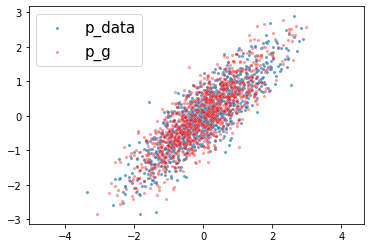

Minimizing divergence: Fkl
mu_pg:
[1.6201 1.5804]

cov_pg:
[[ 0.5085 -0.4789]
 [-0.4789  0.4802]]


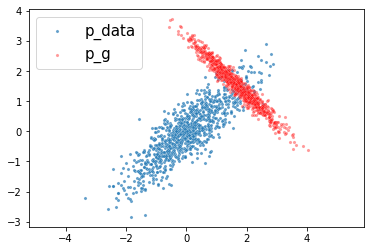

Minimizing divergence: Chi
mu_pg:
[1.3703 1.4636]

cov_pg:
[[ 0.5145 -0.4808]
 [-0.4808  0.4999]]


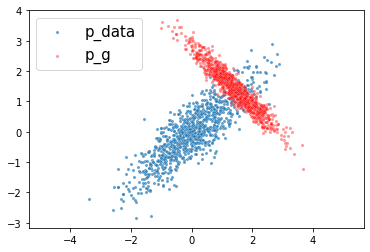

Minimizing divergence: Hellinger
mu_pg:
[1.5803 1.5131]

cov_pg:
[[ 0.1146 -0.0502]
 [-0.0502  0.0647]]


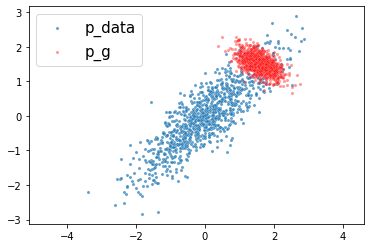

Minimizing divergence: Js
mu_pg:
[1.4924 1.4193]

cov_pg:
[[ 0.1165 -0.0822]
 [-0.0822  0.0957]]


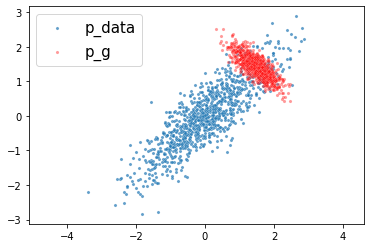

Minimizing divergence: Exp
mu_pg:
[ 0.0369 -0.067 ]

cov_pg:
[[1.0466 0.8204]
 [0.8204 0.8678]]


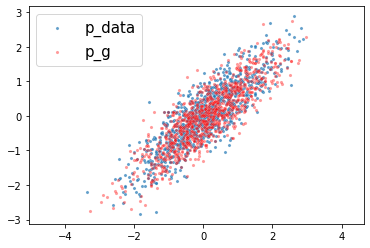

In [6]:
train(func='f', method='Rkl', number_iter=5000, lr=1e-3, lr_d=1e-3, batch_size=32)
train(func='f', method='Fkl', number_iter=5000, lr=1e-3, lr_d=1e-4, batch_size=32)
train(func='f', method='Chi', number_iter=5000, lr=1e-3, lr_d=1e-4, batch_size=32)
train(func='f', method='Hellinger', number_iter=5000, lr=1e-3, lr_d=1e-4, batch_size=32)
train(func='f', method='Js', number_iter=5000, lr=1e-3, lr_d=1e-4, batch_size=32)
train(func='h', method='Exp', number_iter=5000, lr=1e-3, lr_d=1e-4, batch_size=32)